In [1]:
import numpy as np
import pandas as pd
import itertools
import time
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pygam import LinearGAM
from pygam.utils import generate_X_grid
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
data = pd.read_csv('clean_ted_ratings.csv', encoding='latin1')
data.head()

,comments,duration,film_date,languages,main_speaker,num_speaker,published_date,speaker_occupation,title,views,...,Inspiring,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious,Title_Length,Number_Question_marks
0,4553,1164,1140825600,60,Ken Robinson,1,1151367060,Author/educator,Do schools kill creativity?,47227110,...,0.265573,0.004124,0.003197,0.112744,0.047299,0.114054,0.012509,0.002227,4,0
1,265,977,1140825600,43,Al Gore,1,1151367060,Climate advocate,Averting the climate crisis,3200520,...,0.140668,0.038488,0.087875,0.044959,0.039510,0.091281,0.069142,0.044619,4,0
2,124,1286,1140739200,26,David Pogue,1,1151367060,Technology columnist,Simplicity sells,1636292,...,0.081445,0.027620,0.036827,0.058782,0.019122,0.081445,0.051700,0.050283,2,0
3,200,1116,1140912000,35,Majora Carter,1,1151367060,Activist for environmental justice,Greening the ghetto,1697550,...,0.287017,0.014217,0.009657,0.035408,0.061695,0.123391,0.022800,0.009388,3,0
4,593,1190,1140566400,48,Hans Rosling,1,1151440680,Global health expert; data visionary,The best stats you've ever seen,12005869,...,0.112920,0.004294,0.002615,0.179781,0.145824,0.099219,0.009680,0.002381,6,0


In [4]:
#feature encoding- what to do for the title?
#speaker occupation?
#temporarily drop these so we can see what we are working with
data = data.drop('main_speaker', axis = 1)
data = data.drop('speaker_occupation', axis=1)
data = data.drop('title', axis=1)

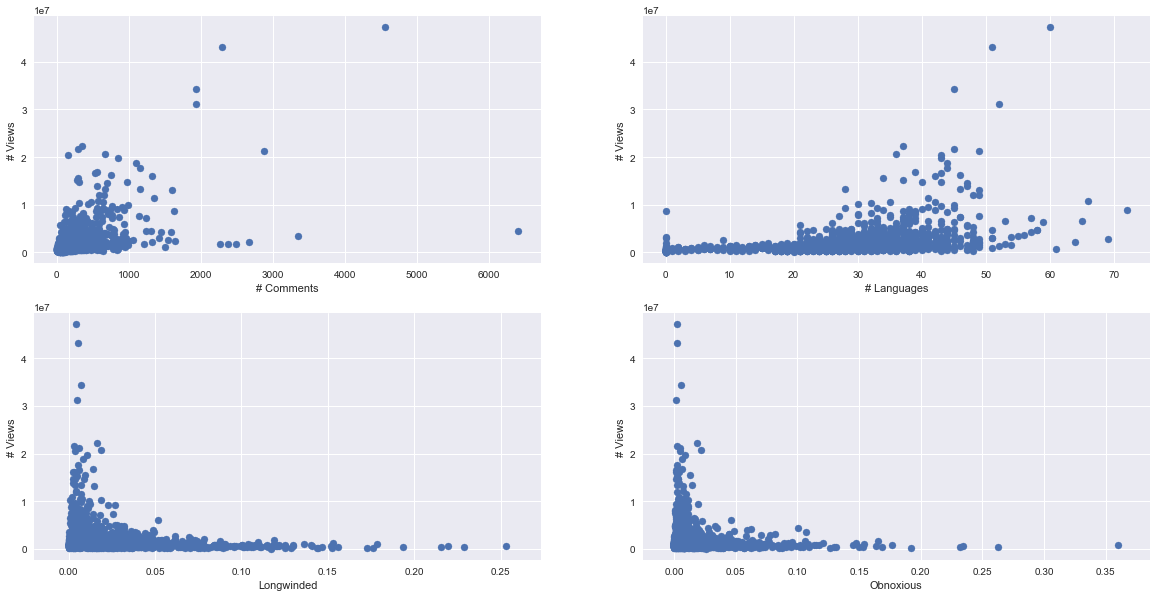

In [5]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.scatter(data['comments'], data['views']);
plt.xlabel('# Comments');
plt.ylabel('# Views');

plt.subplot(2, 2, 2)
plt.scatter(data['languages'], data['views']);
plt.xlabel('# Languages');
plt.ylabel('# Views');

plt.subplot(2, 2, 3)
plt.scatter(data['Longwinded'], data['views']);
plt.xlabel('Longwinded');
plt.ylabel('# Views');

plt.subplot(2, 2, 4)
plt.scatter(data['Obnoxious'], data['views']);
plt.xlabel('Obnoxious');
plt.ylabel('# Views');

### More Feature Engineering

In [6]:
def convert_date_to_year(unix):
    return datetime.fromtimestamp(unix).year

data['published_year'] = data['published_date'].apply(convert_date_to_year)

## Subset Selection

In [8]:
#break down the dataframe into feature set and response set
y = data['views']
X = data.drop('views', axis=1)

In [9]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    #print(list(feature_set))
    model = sm.OLS(y, X[list(feature_set)].astype(float))
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y)**2).sum()
    return {"model":regr, "RSS":RSS}

### Forward Subset Selection

In [10]:
def forward(predictors):
   # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the best RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [11]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names
    #print(predictors)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  23 models on 1 predictors in 0.11846446990966797 seconds.
Processed  22 models on 2 predictors in 0.06248974800109863 seconds.
Processed  21 models on 3 predictors in 0.04687619209289551 seconds.
Processed  20 models on 4 predictors in 0.04687809944152832 seconds.
Processed  19 models on 5 predictors in 0.07599830627441406 seconds.
Processed  18 models on 6 predictors in 0.07600736618041992 seconds.
Processed  17 models on 7 predictors in 0.051445960998535156 seconds.
Processed  16 models on 8 predictors in 0.06250238418579102 seconds.
Processed  15 models on 9 predictors in 0.08000516891479492 seconds.
Processed  14 models on 10 predictors in 0.06773066520690918 seconds.
Processed  13 models on 11 predictors in 0.06251716613769531 seconds.
Processed  12 models on 12 predictors in 0.07600855827331543 seconds.
Processed  11 models on 13 predictors in 0.06005430221557617 seconds.
Processed  10 models on 14 predictors in 0.046877145767211914 seconds.
Processed  9 models on 15 p

In [12]:
#for example, look at the best two variable model
print(models_fwd.loc[4, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     817.0
Date:                Sat, 12 May 2018   Prob (F-statistic):               0.00
Time:                        13:43:16   Log-Likelihood:                -40614.
No. Observations:                2550   AIC:                         8.124e+04
Df Residuals:                    2546   BIC:                         8.126e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
comments      4298.9610    149.167     28.820   

In [13]:
models_fwd.loc[17, "model"].rsquared
#models_fwd.apply(lambda row: row[1].rsquared, axis=1)

0.59461414749517205

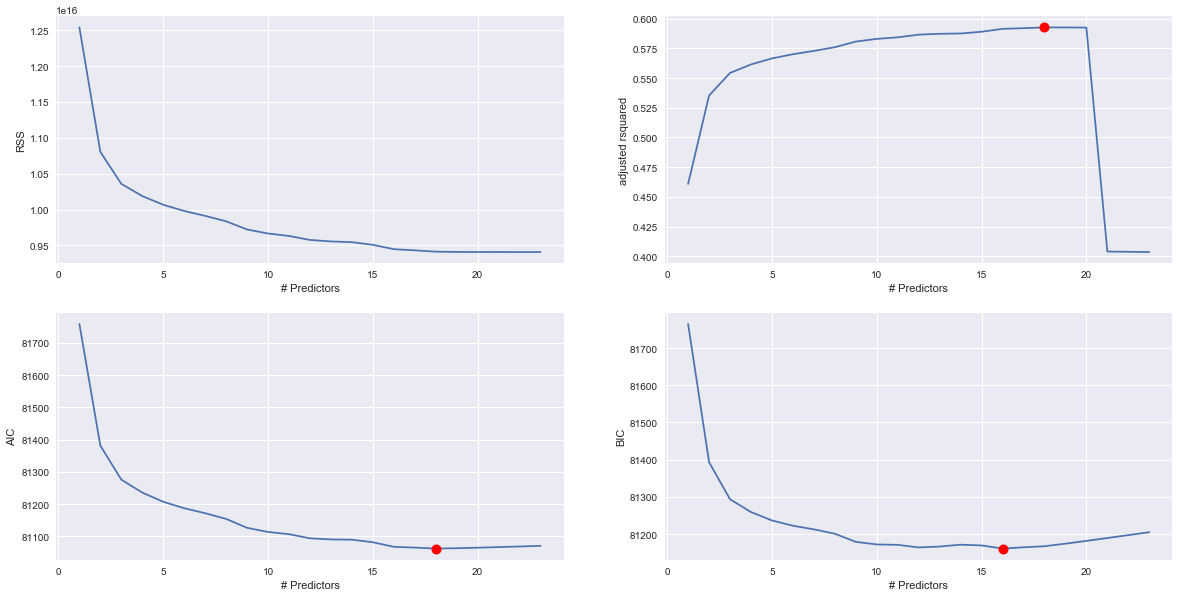

In [15]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)
plt.plot(models_fwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

rsquared_adj = models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [17]:
print(models_fwd.loc[17, "model"].params)

comments          4.309250e+03
languages         6.271705e+04
Unconvincing     -9.970960e+06
Persuasive       -8.838500e+06
Funny            -8.034424e+05
Ingenious        -8.677290e+06
Obnoxious        -1.236192e+07
Title_Length      6.002907e+04
Courageous       -8.629059e+06
OK               -7.447092e+06
Beautiful        -6.093662e+06
Inspiring        -2.271129e+06
Jaw-dropping     -7.581840e+05
Fascinating      -5.210277e+06
published_date    2.729154e-03
Informative      -4.229406e+06
duration          2.426278e+02
dtype: float64


### Backward Selection Using sklearn

In [18]:
lr = LinearRegression()
selector = RFE(lr, n_features_to_select=1)
selector.fit(X,y)
names = X.columns

In [19]:
X.columns

Index(['comments', 'duration', 'film_date', 'languages', 'num_speaker',
       'published_date', 'Beautiful', 'Confusing', 'Courageous', 'Funny',
       'Informative', 'Ingenious', 'Inspiring', 'Longwinded', 'Unconvincing',
       'Fascinating', 'Jaw-dropping', 'Persuasive', 'OK', 'Obnoxious',
       'Title_Length', 'Number_Question_marks', 'published_year'],
      dtype='object')

In [20]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), names)))

Features sorted by their rank:
[(1, 'Longwinded'), (2, 'Obnoxious'), (3, 'Funny'), (4, 'Jaw-dropping'), (5, 'Ingenious'), (6, 'Inspiring'), (7, 'Fascinating'), (8, 'Unconvincing'), (9, 'OK'), (10, 'Beautiful'), (11, 'Courageous'), (12, 'Confusing'), (13, 'Persuasive'), (14, 'Informative'), (15, 'Number_Question_marks'), (16, 'languages'), (17, 'published_year'), (18, 'num_speaker'), (19, 'Title_Length'), (20, 'comments'), (21, 'duration'), (22, 'published_date'), (23, 'film_date')]


### Check to see if linear model is appropriate

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
model = LinearRegression()
model_fit = model.fit(X_train, y_train)
ypred = model_fit.predict(X_test)
#print(ypred)
#print(y_test)

In [24]:
residuals = ypred - y_test
mse_linear_reg = mean_squared_error(y_test, ypred)

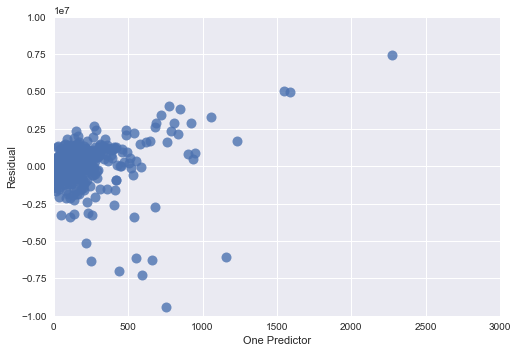

In [25]:
sns.regplot(X_test['comments'], residuals, fit_reg=False);
plt.xlabel('One Predictor');
plt.ylabel('Residual');
plt.xlim(0, 3000);
plt.ylim(-1e7, 1e7);

Conclusions:

- a linear model is not appropriate

- the predictions are currently awful (with all predictors, we need to try doing this with a subset)

## Visualization using PCA/ PCA regression

In [147]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca_std = PCA(n_components=2).fit(X_train_std)
X_train_std = pca_std.transform(X_train_std)
X_test_std = pca_std.transform(X_test_std)

In [148]:
print(pca_std.explained_variance_ratio_)
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_std.shape)

[ 0.18108452  0.12316245]
original shape:    (2040, 23)
transformed shape: (2040, 2)


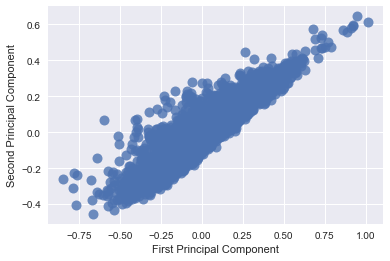

In [149]:
X_new = pca_std.inverse_transform(X_train_std)
sns.regplot(X_new[:, 0], X_new[:, 1], fit_reg=False)
plt.xlabel('First Principal Component');
plt.ylabel('Second Principal Component');

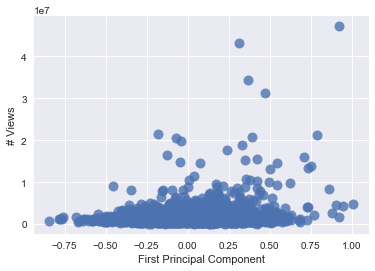

In [159]:
sns.regplot(X_new[:, 0], y_train, fit_reg=False);
plt.xlabel('First Principal Component');
plt.ylabel('# Views');

In [30]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca = PCA()
X_reduced = pca.fit_transform(X_train_std)
n = len(X_reduced)

(-0.2, 5.2)

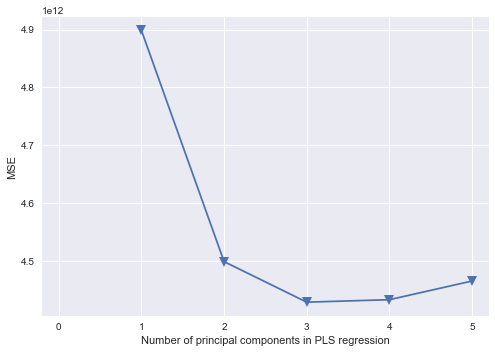

In [31]:
mse = []
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=2)
for i in np.arange(1, 6):
    pls = PLSRegression(n_components=i, scale=False)
    pls.fit(X_reduced,y_train)
    score = cross_validation.cross_val_score(pls, X_reduced, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 6), np.array(mse), '-v')
plt.xlabel('Number of principal components in PLS regression')
plt.ylabel('MSE')
plt.xlim((-0.2, 5.2))

In [32]:
pca_std = PCA(n_components=3).fit(X_train_std)
X_train_std = pca_std.transform(X_train_std)
X_test_std = pca_std.transform(X_test_std)

print(pca_std.explained_variance_ratio_)

[ 0.18108452  0.12316244  0.10443828]


In [33]:
#perform PLS regression
pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [34]:
y_pred = pls.predict(X_test)
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_array = np.asarray(y_pred)

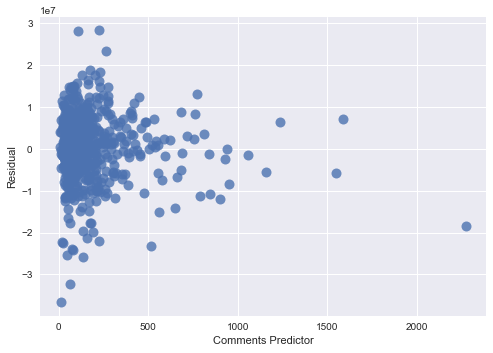

In [36]:
residuals = y_pred_array - y_test
mse_pls_regres = mean_squared_error(y_test, y_pred_array)

sns.regplot(X_test['comments'], residuals, fit_reg=False);
plt.xlabel('Comments Predictor');
plt.ylabel('Residual');

- Why is the residual plot still so bad?
- Predictions are still pretty bad
- Issue: views are never negative, but we are sometimes predicting negative values
    - Solution: Nonnegative least squares regularizer- this did not work very well
    - Another solution- what if we make everything the absolute value of the predicted value?


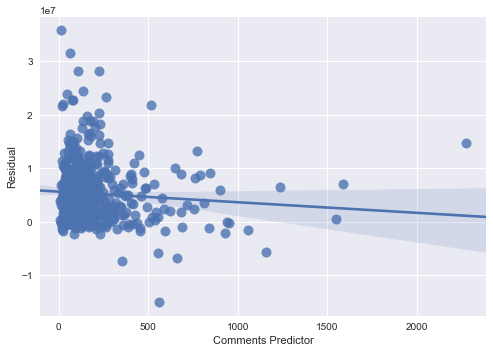

In [37]:
y_pred_positive = [abs(y_pred[i]) for i in range(len(y_pred))]
y_pred_positive = np.asarray(y_pred_positive)
residuals = y_pred_positive - y_test
mse_pls_positive = mean_squared_error(y_test, y_pred_positive)

sns.regplot(X_test['comments'], residuals);
plt.xlabel('Comments Predictor');
plt.ylabel('Residual');

In [155]:
#is PLS regression really doing what I want?
#try it manually
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca_std = PCA(n_components=5).fit(X_train_std)
X_train_std = pca_std.transform(X_train_std)
X_test_std = pca_std.transform(X_test_std)

In [156]:
print(pca_std.explained_variance_ratio_)
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_std.shape)

[ 0.18108452  0.12316244  0.10443817  0.09058987  0.06975127]
original shape:    (2040, 23)
transformed shape: (2040, 5)


In [160]:
#try linear regression and random forest with the compressed data? why not
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 7, 9, 11, 13]}

In [161]:
clf = RandomForestRegressor(random_state=42)
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train_std, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [162]:
print(grid_clf. best_estimator_)
print(grid_clf. best_params_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
{'max_depth': 13, 'n_estimators': 500}


In [163]:
regr = RandomForestRegressor(n_estimators=500, max_depth=13, random_state=42)
regr.fit(X_train_std, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [164]:
y_pred = regr.predict(X_test_std)
residuals = y_pred - y_test

In [165]:
#calculate the MSE
print("MSE: {} ".format(mean_squared_error(y_test, y_pred)))
mse_random_forest_pca = mean_squared_error(y_test, y_pred)

MSE: 4267081079984.644 


## Non-negative Least Squares Regularizer

In [38]:
clf = Lasso(alpha=.001, max_iter=10000, positive=True)
clf.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=True, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
y_pred = clf.predict(X_test)

In [40]:
clf.coef_
#we have positive coefficients, but still have negative predictions

array([  4.35223451e+03,   4.08595917e+02,   0.00000000e+00,
         6.72484465e+04,   0.00000000e+00,   3.23964990e-03,
         4.96915414e+06,   1.28107762e+07,   2.26107550e+06,
         9.92067146e+06,   6.64156674e+06,   2.29333398e+06,
         9.34224212e+06,   6.88283641e+06,   1.68640504e+06,
         5.61845580e+06,   1.15457576e+07,   2.72518603e+06,
         5.17630872e+06,   0.00000000e+00,   4.92428836e+04,
         4.97829721e+04,   0.00000000e+00])

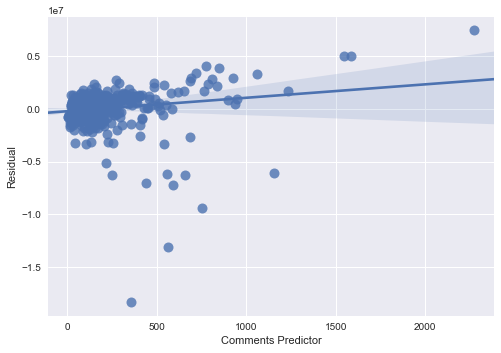

In [41]:
#we still have negative predictions- why?
residuals = y_pred - y_test
mse_nnls = mean_squared_error(y_pred, y_test)

sns.regplot(X_test['comments'], residuals);
plt.xlabel('Comments Predictor');
plt.ylabel('Residual');

## Non Linear Modeling

In [44]:
#need to specify basis functions for each predictor- cannot do this for the entire matrix
transformed_x2 = dmatrix("bs(X_train.languages, df=5, include_intercept=False)",
                         {"X_train.languages": X_train['languages']}, return_type='dataframe')
fit2 = sm.GLM(y_train, transformed_x2).fit()

In [45]:
fit2.params

Intercept                                                  5.991519e+05
bs(X_train.languages, df=5, include_intercept=False)[0]   -1.673338e+05
bs(X_train.languages, df=5, include_intercept=False)[1]    4.748645e+05
bs(X_train.languages, df=5, include_intercept=False)[2]    8.196652e+05
bs(X_train.languages, df=5, include_intercept=False)[3]    1.411775e+07
bs(X_train.languages, df=5, include_intercept=False)[4]    5.246839e+06
dtype: float64

In [46]:
language_grid = np.arange(X_train.languages.min(), X_train.languages.max()).reshape(-1,1)

pred = fit2.predict(dmatrix("bs(language_grid, df=5, include_intercept=False)",
                         {"language_grid": language_grid}, return_type='dataframe'))

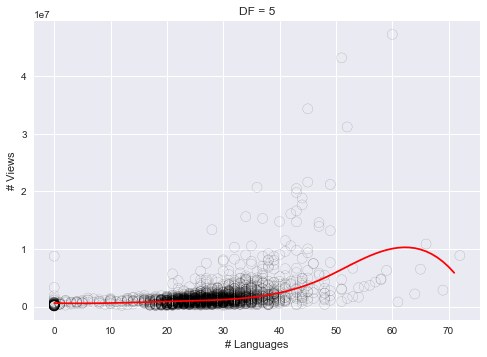

In [48]:
plt.scatter(X_train.languages, y_train, facecolor='None', edgecolor='k', alpha=0.3);
plt.plot(language_grid, pred, color='r');
#plt.ylim(0,10000000);
plt.xlabel('# Languages');
plt.ylabel('# Views');
plt.title('DF = 5');

## GAMs with Regression Splines

In [50]:
#use an ANOVA test to determine the best possible model
#should go back to our feature selection to make life a lot easier
#how about we choose a 10 variable model, fit a GAM, and see how it does
#go from there

In [51]:
select_features = ['comments', 'languages', 'Obnoxious']
X_train_gam = X_train[list(select_features)]
y_train_gam = y_train
X_test_gam = X_test[list(select_features)]
y_test_gam = y_test

In [52]:
gam = LinearGAM().fit(X_train_gam, y_train_gam)

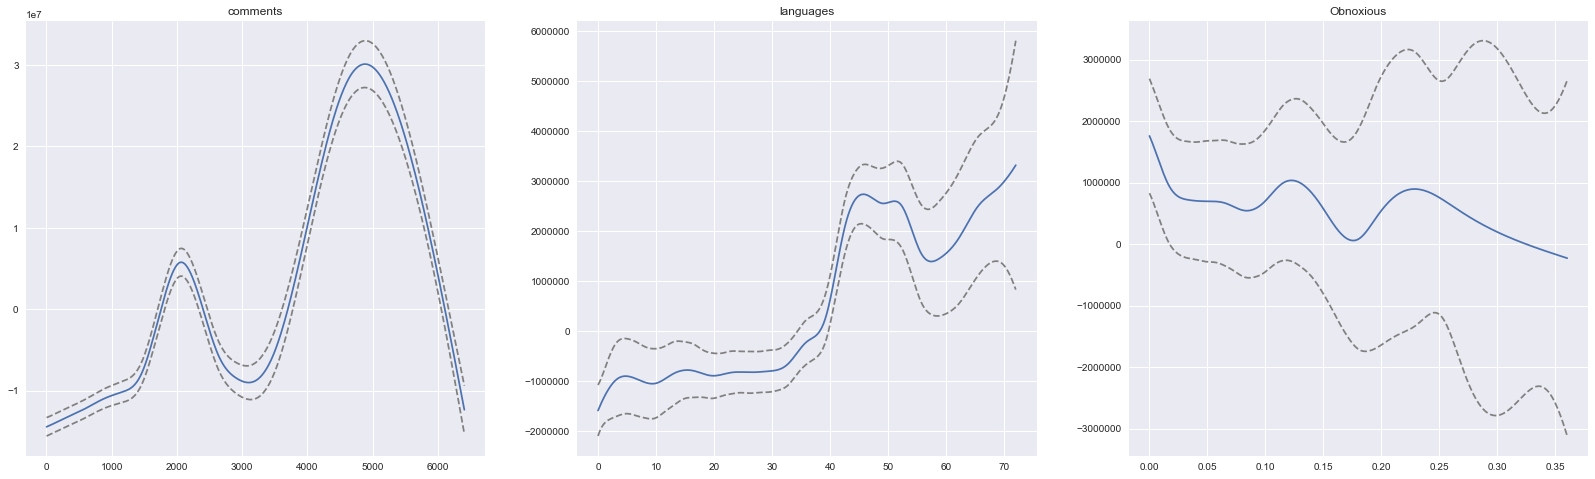

In [53]:
XX = generate_X_grid(gam)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(X_train_gam.columns))
titles = X_train_gam.columns
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i])
plt.show()

In [54]:
predictions = gam.predict(X_test_gam)
print("MSE: {} ".format(mean_squared_error(y_test_gam, predictions)))

MSE: 3749420342901.5054 


In [55]:
gam = LinearGAM().gridsearch(X_train_gam, y_train_gam)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [56]:
lambda_ = 0.6
n_splines = [4, 5, 10, 12, 15] 
constraints = None
X_train, X_test, y_train, y_test = train_test_split(X[list(select_features)], y, test_size=0.33, random_state=42)
for i in n_splines:
    gam = LinearGAM(constraints=constraints, 
                      lam=lambda_,
                     n_splines=i).fit(X_train, y_train)
    predictions = gam.predict(X_test)
    print("MSE: {} ".format(mean_squared_error(y_test, predictions)), 'Number splines: {}'.format(i))

MSE: 4004974743439.178  Number splines: 4
MSE: 4641448463738.089  Number splines: 5
MSE: 11191007464070.666  Number splines: 10
MSE: 14584162436143.537  Number splines: 12
MSE: 18027689319160.414  Number splines: 15


In [57]:
def processSubset_nonlinear(feature_set):
    # Fit model on feature_set and calculate RSS
    model = LinearGAM(lam = 0.6, n_splines = 4)
    regr = model.fit(X[list(feature_set)], y)
    MSE = mean_squared_error(regr.predict(X[list(feature_set)]), y)
    return {"model":regr, "MSE":MSE, 'predictors': feature_set}

In [58]:
def forward_nonlinear(predictors):
   # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset_nonlinear(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the best MSE
    best_model = models.loc[models['MSE'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [59]:
models_fwd = pd.DataFrame(columns=["MSE", "model", 'predictors'])
tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward_nonlinear(predictors)
    predictors = models_fwd.loc[i]['predictors']

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  23 models on 1 predictors in 0.667076826095581 seconds.
Processed  22 models on 2 predictors in 0.82503342628479 seconds.
Processed  21 models on 3 predictors in 1.1636943817138672 seconds.
Processed  20 models on 4 predictors in 1.1037461757659912 seconds.
Processed  19 models on 5 predictors in 1.2099335193634033 seconds.
Processed  18 models on 6 predictors in 1.6695489883422852 seconds.
Processed  17 models on 7 predictors in 1.51271390914917 seconds.
Processed  16 models on 8 predictors in 1.5698373317718506 seconds.
Processed  15 models on 9 predictors in 2.0720932483673096 seconds.
Processed  14 models on 10 predictors in 2.2360525131225586 seconds.
Processed  13 models on 11 predictors in 2.0234286785125732 seconds.
Processed  12 models on 12 predictors in 2.0500829219818115 seconds.
Processed  11 models on 13 predictors in 1.9340734481811523 seconds.
Processed  10 models on 14 predictors in 2.0666773319244385 seconds.
Processed  9 models on 15 predictors in 2.151374

In [60]:
#for example, look at the best two variable model
print(models_fwd.loc[17, "model"].summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     22.8239
Link Function:                     IdentityLink Log Likelihood:                                -75989.4039
Number of Samples:                         2550 AIC:                                           152026.4556
                                                AICc:                                           152026.924
                                                GCV:                                     3.54676391702e+12
                                                Scale:                                   3.48966794738e+12
                                                Pseudo R-Squared:                                   0.4458
Feature Function   Data Type      Num

In [61]:
models_fwd.loc[17, "model"].statistics_['AIC']

152026.45558434588

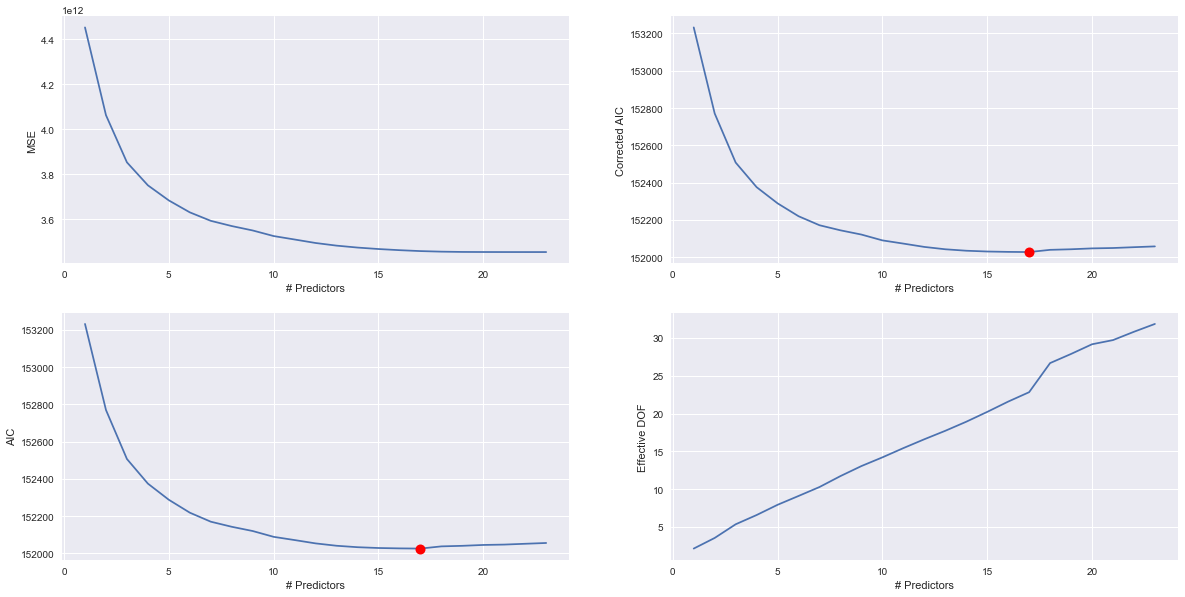

In [62]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)
plt.plot(models_fwd["MSE"]);
plt.xlabel('# Predictors');
plt.ylabel('MSE');

AICc = models_fwd.apply(lambda row: row[1].statistics_['AICc'], axis=1)

plt.subplot(2, 2, 2)
plt.plot(AICc);
plt.plot(AICc.argmin(), AICc.min(), "or");
plt.xlabel('# Predictors');
plt.ylabel('Corrected AIC');

aic = models_fwd.apply(lambda row: row[1].statistics_['AIC'], axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic);
plt.plot(aic.argmin(), aic.min(), "or");
plt.xlabel('# Predictors');
plt.ylabel('AIC');

dof = models_fwd.apply(lambda row: row[1].statistics_['edof'], axis=1)

plt.subplot(2, 2, 4)
plt.plot(dof);
plt.xlabel('# Predictors');
plt.ylabel('Effective DOF');

In [63]:
#17 variable model still has the lowest AIC (predictions still pretty bad- how can we make sure they are all positive?)

In [64]:
models_fwd.loc[17, 'predictors']

['comments',
 'languages',
 'published_year',
 'Unconvincing',
 'Funny',
 'duration',
 'Persuasive',
 'Courageous',
 'Inspiring',
 'Jaw-dropping',
 'Ingenious',
 'Beautiful',
 'Obnoxious',
 'published_date',
 'Fascinating',
 'Title_Length',
 'Confusing']

In [66]:
#make a residual plot and see if this model is more appropriate- hopefully this gives us something good
select_features = models_fwd.loc[17, 'predictors']
X_train, X_test, y_train, y_test = train_test_split(X[list(select_features)], y, test_size=0.33, random_state=42)

In [67]:
gam = LinearGAM().fit(X_train, y_train)

In [68]:
predictions = gam.predict(X_test)
print("MSE: {} ".format(mean_squared_error(y_test, predictions)))
mse_gam_select_features = mean_squared_error(y_test, predictions)

MSE: 18856927789331.254 


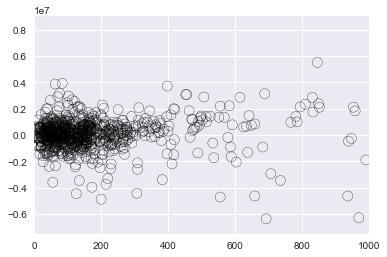

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
residuals = predictions - y_test
plt.scatter(X_test['comments'], residuals, facecolor='None', edgecolor='k');
plt.xlim(0, 1000);
plt.ylim(-.75e7, .9e7);

In [70]:
#does the MSE go down if we take the absolute value of the predictions? (this is terrible practice but how can we add a 
#non negative regularizer when we are using regression splines?)
predictions = gam.predict(X_test)
print("MSE: {} ".format(mean_squared_error(y_test, np.abs(predictions))))
#goes down a little bit

MSE: 18724286580590.734 


ideas from here on out:
- random forest regressor

## Random Forest Regressor

In [71]:
param_grid = {'n_estimators': [20, 50, 100, 200, 500], 'max_depth': [5, 7, 9, 11, 13]}

In [72]:
# clf = RandomForestRegressor(random_state=42)
# grid_clf = GridSearchCV(clf, param_grid, cv=10)
# grid_clf.fit(X_train, y_train)

In [73]:
#print(grid_clf. best_estimator_)
#print(grid_clf. best_params_)

NameError: name 'grid_clf' is not defined

In [130]:
select_features = models_fwd.loc[17, 'predictors']
X_train, X_test, y_train, y_test = train_test_split(X[list(select_features)], y, test_size=0.33, random_state=42)

In [131]:
regr = RandomForestRegressor(n_estimators=100, max_depth=13, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [132]:
regr.score(X_test, y_test)
#terrible R^2 score lol

0.39857756235223962

17


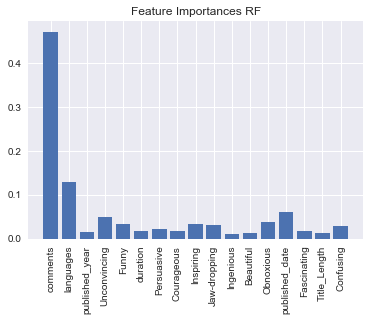

In [133]:
labels = X_train.columns
x_axis = np.arange(17)
impo = regr.feature_importances_

plt.bar(x_axis, impo, align='center');
plt.xticks(x_axis, labels, rotation='vertical');
plt.title('Feature Importances RF');
print(regr.n_features_)

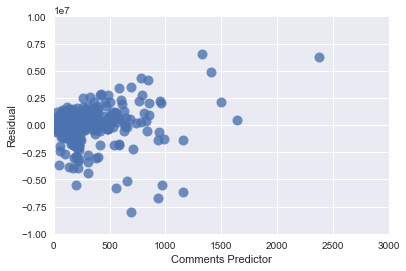

In [134]:
y_pred = regr.predict(X_test)

residuals = y_pred - y_test
sns.regplot(X_test['comments'], residuals, fit_reg=False);
plt.xlabel('Comments Predictor');
plt.ylabel('Residual');
plt.xlim(0, 3000);
plt.ylim(-1e7, 1e7);

In [135]:
#calculate the MSE
print("MSE: {} ".format(mean_squared_error(y_test, y_pred)))
mse_random_forest_17 = mean_squared_error(y_test, y_pred)

MSE: 2119970228606.3184 


In [140]:
#MSE using all predictors for a random forest regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [120]:
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [9, 11, 13, 15, 17]}

In [121]:
clf = RandomForestRegressor(random_state=42)
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500], 'max_depth': [9, 11, 13, 15, 17]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [122]:
print(grid_clf. best_estimator_)
print(grid_clf. best_params_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
{'max_depth': 13, 'n_estimators': 200}


In [141]:
regr = RandomForestRegressor(n_estimators=200, max_depth=13, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [142]:
regr.score(X_test, y_test)
#terrible R^2 score lol

0.40335811045956027

In [143]:
print(len(X_train.columns))

23


23


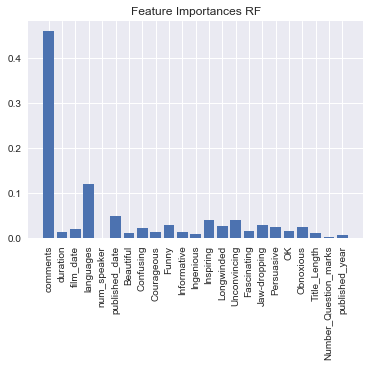

In [144]:
labels = X_train.columns
x_axis = np.arange(23)
impo = regr.feature_importances_

plt.bar(x_axis, impo, align='center');
plt.xticks(x_axis, labels, rotation='vertical');
plt.title('Feature Importances RF');
print(regr.n_features_)

In [145]:
#get a dictionary of the top features
impo = regr.feature_importances_
labels = X_train.columns
features_rf = {}
for i in range(len(impo)):
    features_rf[labels[i]] = impo[i] 
print(features_rf)

{'comments': 0.45936589503219738, 'duration': 0.012731300412900872, 'film_date': 0.019658420399723559, 'languages': 0.12038178725227688, 'num_speaker': 0.00025924838202513864, 'published_date': 0.04986333956702578, 'Beautiful': 0.011900322222972754, 'Confusing': 0.022201558397798665, 'Courageous': 0.013222495312408038, 'Funny': 0.029711663805796321, 'Informative': 0.013547408255915454, 'Ingenious': 0.0081813017347589761, 'Inspiring': 0.04021013012339554, 'Longwinded': 0.02714696708159459, 'Unconvincing': 0.039701985183355458, 'Fascinating': 0.014822660531477799, 'Jaw-dropping': 0.028846007020943473, 'Persuasive': 0.023988304680792476, 'OK': 0.01653569410837841, 'Obnoxious': 0.02531763730612285, 'Title_Length': 0.01231471177686231, 'Number_Question_marks': 0.002938787317476666, 'published_year': 0.0071523740938006994}


We compare this to the subset selection from backward selection:

The rankings here are: comments, languages, published_date, Unconvincing, Inspiring
The rankings before were: [(1, 'Longwinded'), (2, 'Obnoxious'), (3, 'Funny'), (4, 'Jaw-dropping'), (5, 'Ingenious'), (6, 'Inspiring'), (7, 'Fascinating'), (8, 'Unconvincing'), (9, 'OK'), (10, 'Beautiful'), (11, 'Courageous'), (12, 'Confusing'), (13, 'Persuasive'), (14, 'Informative'), (15, 'Number_Question_marks'), (16, 'languages'), (17, 'published_year'), (18, 'num_speaker'), (19, 'Title_Length'), (20, 'comments'), (21, 'duration'), (22, 'published_date'), (23, 'film_date')]

I am more convinced from the random forest. Backward selection seemed to do a bad job.

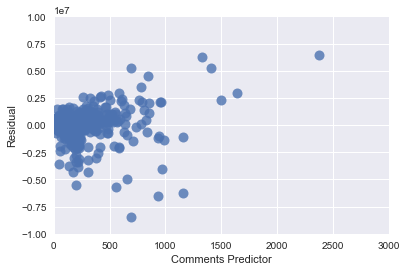

In [128]:
y_pred = regr.predict(X_test)
residuals = y_pred - y_test
sns.regplot(X_test['comments'], residuals, fit_reg=False);
plt.xlabel('Comments Predictor');
plt.ylabel('Residual');
plt.xlim(0, 3000);
plt.ylim(-1e7, 1e7);

In [129]:
#calculate the MSE
print("MSE: {} ".format(mean_squared_error(y_test, y_pred)))
mse_random_forest_all = mean_squared_error(y_test, y_pred)

MSE: 2103119145192.1746 


## MSE of different Models

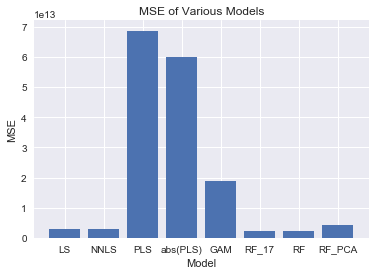

In [167]:
x_axis = [1,2,3,4,5,6,7,8]
MSE = [mse_linear_reg, mse_nnls, mse_pls_regres, mse_pls_positive, mse_gam_select_features, mse_random_forest_17,
      mse_random_forest_all, mse_random_forest_pca]
LABELS = ['LS', 'NNLS', 'PLS', 'abs(PLS)', 'GAM', 'RF_17', 'RF', 'RF_PCA']

plt.bar(x_axis, MSE, align='center');
plt.xticks(x_axis, LABELS);
plt.title('MSE of Various Models');
plt.xlabel('Model');
plt.ylabel('MSE');

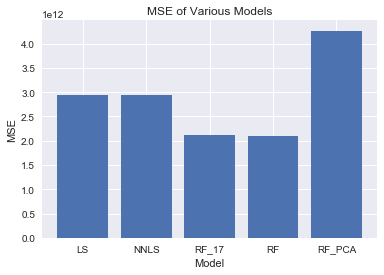

In [166]:
x_axis = [1,2,3,4,5]
MSE = [mse_linear_reg, mse_nnls, mse_random_forest_17,mse_random_forest_all, mse_random_forest_pca]
LABELS = ['LS', 'NNLS', 'RF_17', 'RF', 'RF_PCA']

plt.bar(x_axis, MSE, align='center');
plt.xticks(x_axis, LABELS);
plt.title('MSE of Various Models');
plt.xlabel('Model');
plt.ylabel('MSE');

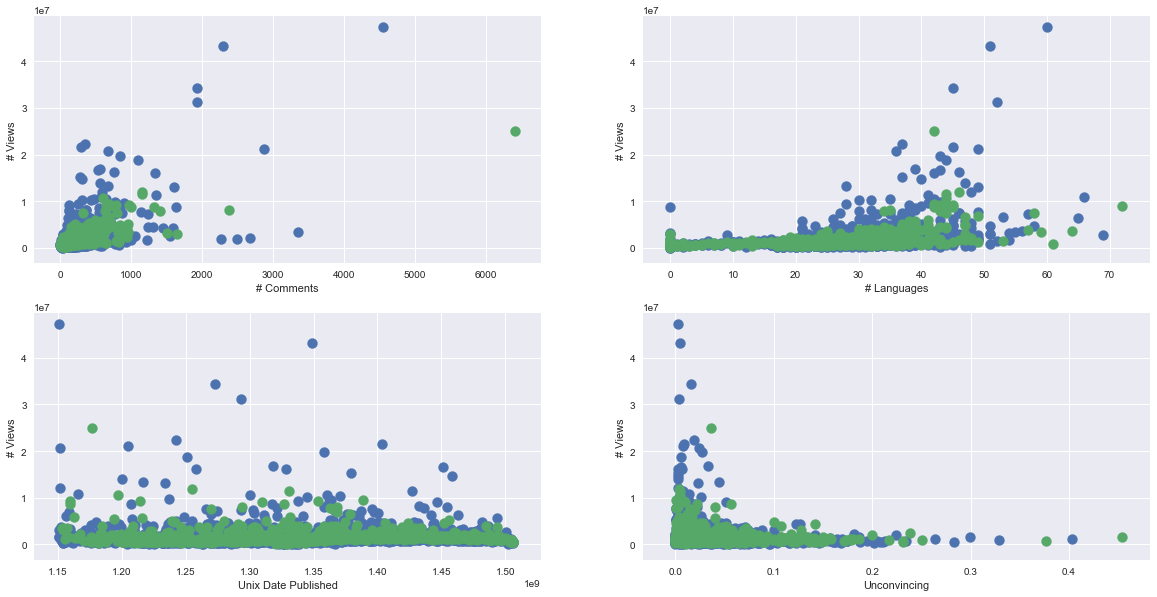

In [115]:
#visualize the actual views versus the predictions for various features
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.scatter(X_train['comments'], y_train);
plt.scatter(X_test['comments'], y_pred);
plt.xlabel('# Comments');
plt.ylabel('# Views');

plt.subplot(2, 2, 2)
plt.scatter(X_train['languages'], y_train);
plt.scatter(X_test['languages'], y_pred);
plt.xlabel('# Languages');
plt.ylabel('# Views');

plt.subplot(2, 2, 3)
plt.scatter(X_train['published_date'], y_train);
plt.scatter(X_test['published_date'], y_pred);
plt.xlabel('Unix Date Published');
plt.ylabel('# Views');

plt.subplot(2, 2, 4)
plt.scatter(X_train['Unconvincing'], y_train);
plt.scatter(X_test['Unconvincing'], y_pred);
plt.xlabel('Unconvincing');
plt.ylabel('# Views');

Things to do:
- do we do subset selection with a linear model- or something else? will they always give the same predictors?
- if so, we should do a subset selection for different methods if we can